# Using data from Chang+15, look in to SFRs etc.

In [1]:
os.chdir('../')

In [2]:
from astropy.table import Table

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import urllib
from PIL import Image

colors_long = ['orange','r','magenta','g','blue','cyan','k']

In [3]:
data = Table.read('../fits/full_sample_debiased.fits')
print('Loaded galaxy data...')
sw_input = Table.read('../fits/Chang_15/sw_input.fits')
sw_output = Table.read('../fits/Chang_15/sw_output.fits')
print('Loaded C15 data...')
gz_to_nyu = Table.read('../fits/Chang_15/gz_to_nyu.fits')
print('Loaded indices.')

Loaded galaxy data...
Loaded C15 data...
Loaded indices.


In [4]:
# Get corresponding columns between C15 and GZ catalogue:
i = gz_to_nyu['i'].astype(int)
sw_input_gz = sw_input[i]
sw_output_gz = sw_output[i]

In [5]:
os.chdir('../Debiasing/')
import make_dictionaries
questions = make_dictionaries.questions

In [6]:
# Mass limit from Chang+15?
z_limit = 0.085
mass_limit = 10.6 + 2.28*math.log10(z_limit/0.1)
in_mass_limit = sw_output_gz['lmass50_all'] > mass_limit
print('Mass limit: M* > {0:.2f}'.format(mass_limit))

Mass limit: M* > 10.44


In [7]:
def get_spiral_sample(data,questions,in_mass_limit=None,printout=True,p_th=None):

    in_volume_limit = data['in_volume_limit'] == True
    select_p = (data['t01_smooth_or_features_a02_features_or_disk_debiased_rh']
                *data['t02_edgeon_a05_no_debiased_rh']*data['t04_spiral_a08_spiral_debiased_rh']) > 0.5
    select_N = (data['t04_spiral_a08_spiral_count'] - data['t11_arms_number_a37_cant_tell_count']) >= 5
    
    if in_mass_limit == None:
        select = (in_volume_limit) & (select_p) & (select_N)
    else:
        select = (in_volume_limit) & (select_p) & (select_N) & (in_mass_limit)
        
    answers = questions['t11_arms_number']['answers'][:-1]
    arm_answers = ['t11_arms_number_' + A + '_debiased_rh' for A in answers]
    arm_array = np.array([data[A] for A in arm_answers]).T
    arm_assignments = np.argmax(arm_array,axis=1)
    if p_th != None:
        p_values = np.max(arm_array,axis=1)
        arm_assignments[p_values < p_th] = -999
        
    if printout:
        print('{}/{} selected'.format(np.sum(select),len(select)))
        for m in range(5):
            print('m={}: {}/{} spiral galaxies selected'.format(m+1,np.sum(arm_assignments[select] == m)
                                                         ,len(arm_assignments[select] == m)))
    
    return select,arm_assignments

In [8]:
select_spirals,m_values = get_spiral_sample(data,questions,in_mass_limit,p_th=0)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in less


14385/228201 selected
m=1: 722/14385 spiral galaxies selected
m=2: 9293/14385 spiral galaxies selected
m=3: 2597/14385 spiral galaxies selected
m=4: 862/14385 spiral galaxies selected
m=5: 911/14385 spiral galaxies selected


# SF diagrams

In [9]:
def sf_selection(ur,rz):
    sf = (ur < 2.1) or ur < 1.6*rz + 1.1
    return sf


def sf_line(rz):
    
    select = rz < 1/1.6
    ur = np.zeros(len(rz))
    ur[select] = 2.1
    ur[select == False] = 1.6*(rz[select == False]) + 1.1
    
    return ur

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


14124/14385 spirals with good chi2


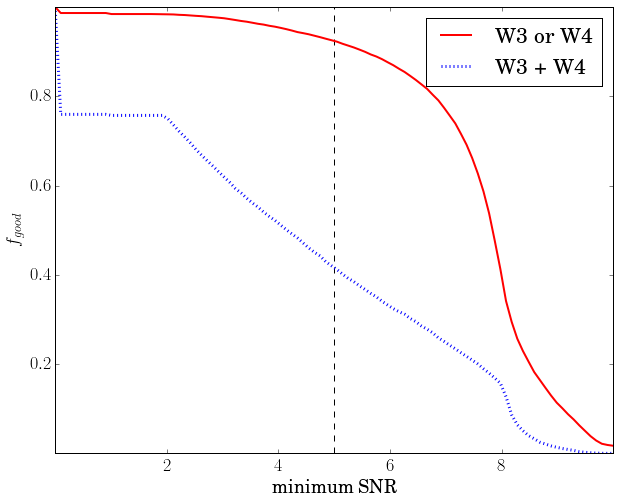

In [10]:
# Get flux/fluxerror values

w3_snr = sw_input_gz['flux_w3']/sw_input_gz['flux_w3_e']
w4_snr = sw_input_gz['flux_w4']/sw_input_gz['flux_w4_e']

# Cut out any galaxies which are bad in W3 + W4:

w3_snr_spirals = w3_snr[select_spirals]
w4_snr_spirals = w4_snr[select_spirals]
good_chi2 = sw_output_gz[select_spirals]['flag_chi2'] == 1

print('{}/{} spirals with good chi2'.format(np.sum(good_chi2),len(good_chi2)))

total_spirals = len(w3_snr_spirals)
snr_vals = np.linspace(0,10,100)
fracs_either = []
fracs_both = []

for snr_min in snr_vals:
    
    good_w3 = w3_snr_spirals > snr_min
    good_w4 = w4_snr_spirals > snr_min
    good_wise_either = [any(g) for g in zip(good_w3,good_w4)]
    good_wise_both = (good_w3) & (good_w4)
    fracs_either.append(np.sum(good_wise_either)/total_spirals)
    fracs_both.append(np.sum(good_wise_both)/total_spirals)
    
plt.plot(snr_vals,fracs_either,'r-',lw=2,label='W3 or W4')
plt.plot(snr_vals,fracs_both,'b:',lw=3,label='W3 + W4')
plt.vlines(5,0,1,color='k',linestyle='dashed')
plt.xlabel('minimum SNR')
plt.ylabel('$f_{good}$')
_ = plt.legend()

In [11]:
good_w3 = w3_snr_spirals > 5
good_w4 = w4_snr_spirals > 5
good_wise_either = [any(g) for g in zip(good_w3,good_w4)]
good_wise_both = (good_w3) & (good_w4)

good = (good_wise_either) & (good_chi2)
print('{}/{} w. snr > 5 in either W3 or W4'.format(np.sum(good),len(good)))

13116/14385 w. snr > 5 in either W3 or W4


In [12]:
def plot_hists(data1,data2,bins,xlabel,legend=False,labels=['good','all spirals']):

    _ = plt.hist(data1,color='g',histtype='stepfilled',alpha=0.5,normed=True,bins=bins,label=labels[0])
    _ = plt.hist(data2,color='r',histtype='step',lw=3,normed=True,bins=bins,label=labels[1])
    plt.xlabel(xlabel)
    plt.ylabel('normalised density')
    if legend:
        _ = plt.legend()
    
    return None

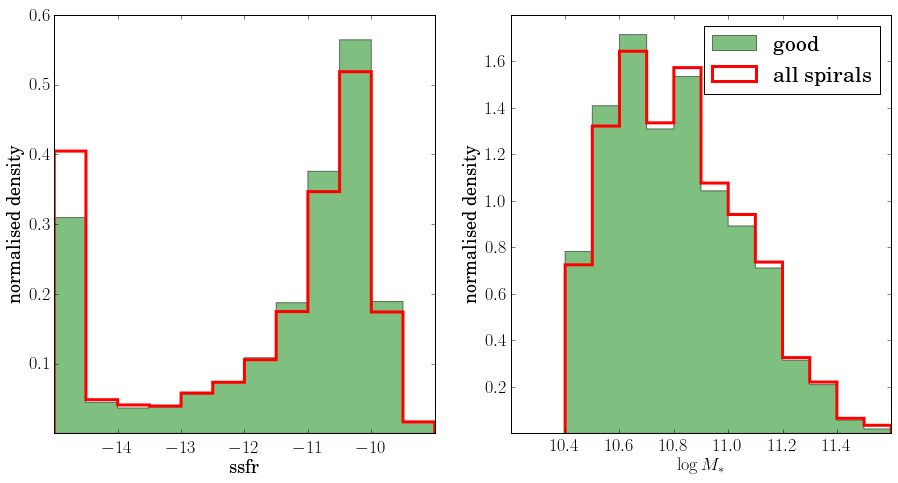

In [13]:
fig,axarr = plt.subplots(1,2,figsize=(15,7.5))

plt.sca(axarr[0])
plot_hists(data1=sw_output_gz[select_spirals][good]['lssfr50_all'],
           data2=sw_output_gz[select_spirals]['lssfr50_all'],
           bins=np.linspace(-15,-9,13),xlabel='ssfr')
plt.sca(axarr[1])
plot_hists(data1=sw_output_gz[select_spirals][good]['lmass50_all'],
           data2=sw_output_gz[select_spirals]['lmass50_all'],
           bins=np.linspace(10.4,11.6,13),xlabel='$\log M_*$',legend=True)

# Compare SFRs using different measures

In [14]:
from scipy.stats import binned_statistic

def bin_by_column(column, nbins, fixedcount=True):
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins

In [15]:
# Plot SFR and mass relations for the new catalogues:
from scipy.stats import binned_statistic
import scipy.stats.distributions as dist

def get_arm_fraction(column,bins,m):
    
    N_b = len(np.unique(bins))
    fractions = np.zeros(N_b)
    upper_fracs = np.zeros(N_b)
    lower_fracs = np.zeros(N_b)
    
    for n,b in enumerate(np.unique(bins)):
        
        bin_col = column[bins == b]
        bin_m = np.sum(bin_col == m)
        bin_tot = len(bin_col)
        
        f_low,f_high = get_fractional_errors(bin_m,bin_tot)
        fractions[n] = bin_m/bin_tot
        lower_fracs[n] = f_low
        upper_fracs[n] = f_high
    
    fractions_table = Table(np.array([lower_fracs,fractions,upper_fracs]).T
                            ,names=('low_f','f','high_f'))
    
    return fractions_table


def get_fractional_errors(k,n,c=0.683):
    
    p_lower = dist.beta.ppf((1-c)/2.,k+1,n-k+1)
    p_upper = dist.beta.ppf(1-(1-c)/2.,k+1,n-k+1)
    
    return p_lower,p_upper


def bin_by_column(column, nbins, fixedcount=True):
    sorted_indices = np.argsort(column)
    if fixedcount:
        bin_edges = np.linspace(0, 1, nbins + 1)
        bin_edges[-1] += 1
        values = np.empty(len(column))
        values[sorted_indices] = np.linspace(0, 1, len(column))
        bins = np.digitize(values, bins=bin_edges)
    else:
        bin_edges = np.linspace(np.min(column),np.max(column), nbins + 1)
        bin_edges[-1] += 1
        values = column
        bins = np.digitize(values, bins=bin_edges)
    x, b, n = binned_statistic(values, column, bins=bin_edges)
    return x, bins

In [16]:
def histograms(column,assignments,axarr,bins,
               reference_column=None,linestyle='solid',linewidth=3,ref_col='k',
               mean_lines=False,ylims=None):
    
    labels = questions['t11_arms_number']['answerlabels']
    
    for m,ax in enumerate(axarr):
        
        column_m = column[assignments == m]
        
        if reference_column != None:
            _ = ax.hist(reference_column,bins,histtype='stepfilled',alpha=0.3,
                        color=ref_col,normed=True)
        
        if column != None:
            _ = ax.hist(column_m,bins,histtype='step',linestyle=linestyle,
                        color=colors_long[m],linewidth=linewidth,normed=True)
            
        if mean_lines == True:
            #yl = plt.gca().get_ylim()
            ax.vlines(np.mean(column_m),ylims[0],ylims[1],color=colors_long[m],
                       linewidth=2,linestyle='dashed')
            ax.vlines(np.mean(column_m)-np.std(column_m),ylims[0],ylims[1],color=colors_long[m],
                       linewidth=2,linestyle='dashed')
            ax.vlines(np.mean(column_m)+np.std(column_m),ylims[0],ylims[1],color=colors_long[m],
                       linewidth=2,linestyle='dashed')
        
        ax.set_ylabel('normalised \n density')
        ax.text(0.975,0.9,'m={} ({} galaxies)'.format(labels[m],len(column_m))
                ,transform=ax.transAxes,ha='right',va='top')
        
    return fig,axarr


def lines(column,assignments,axarr,nbins=20):
    
    labels = questions['t11_arms_number']['answerlabels']
    
    z,bins = bin_by_column(column,nbins)

    for m,ax in enumerate(axarr):
        
        column_m = column[assignments == m]
        
        fracs = get_arm_fraction(assignments,bins,m)
        axarr[m].plot(z,fracs['f'],linewidth=2,linestyle='solid',color=colors_long[m])
        axarr[m].fill_between(z,fracs['low_f'],fracs['high_f'],color=colors_long[m],alpha=0.5)

        ax.set_ylabel('$f_\mathrm{{m=' + '{}'.format(labels[m]) + '}}$')
        
    return fig,axarr

/home/ppxrh/anaconda3/lib/python3.4/site-packages/astropy/table/column.py:206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return self.data.__ne__(other)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


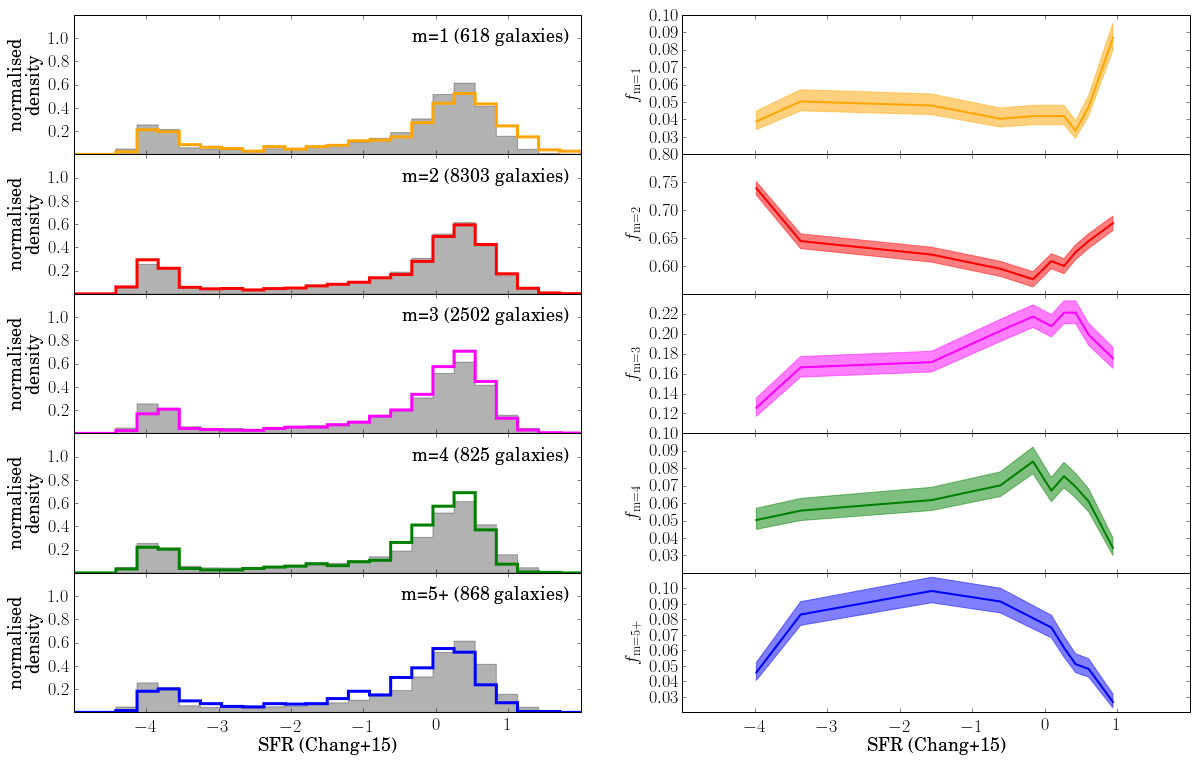

In [17]:
fig,axarr = plt.subplots(5,2,figsize=(20,12.5),sharex=True,sharey=False)
plt.subplots_adjust(hspace=0,wspace=0.2)

column = sw_output_gz[select_spirals][good]['lsfr50_all']
arms_good = m_values[select_spirals][good]

axarr1 = axarr[:,0]
axarr2 = axarr[:,1]

for ax in axarr[-1]:
    ax.set_xlabel('SFR (Chang+15)')

histograms(column,arms_good,axarr1,np.linspace(-5,2,25),
           reference_column=column)

lines(column,arms_good,axarr2,nbins=10)

axarr = axarr.ravel()

for ax in axarr1:
    ax.set_ylim(0,1.2)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/astropy/table/column.py:206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return self.data.__ne__(other)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


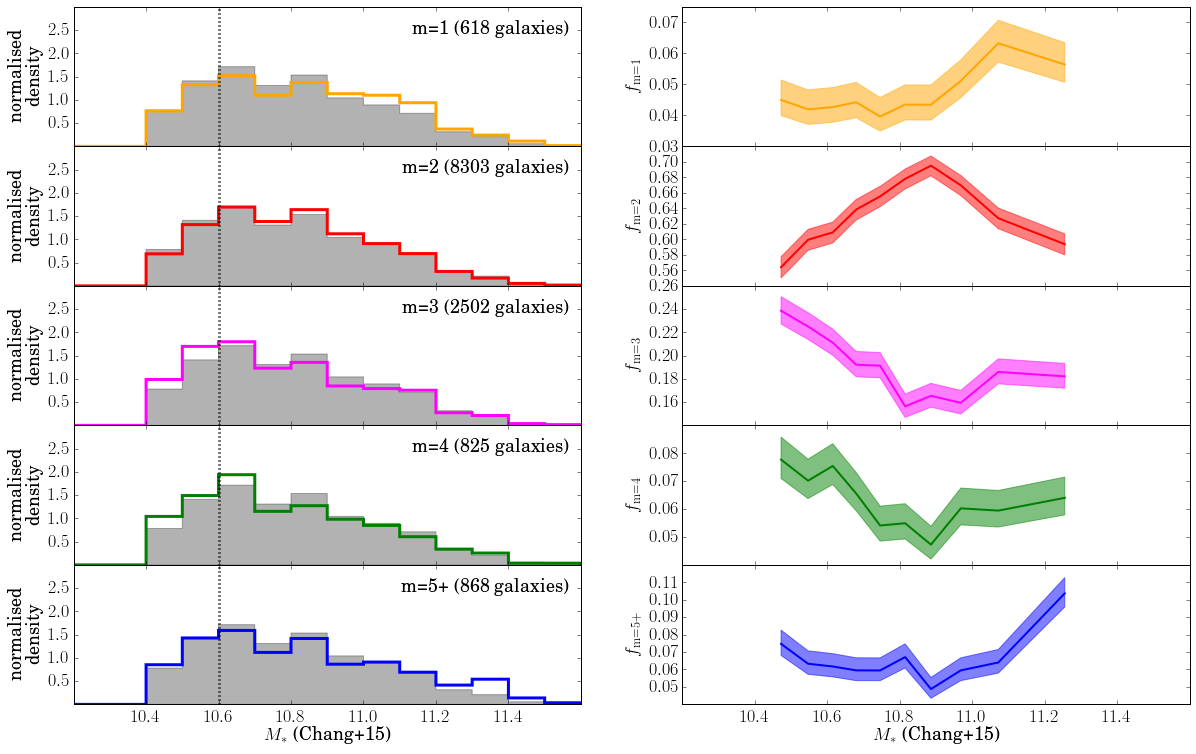

In [18]:
fig,axarr = plt.subplots(5,2,figsize=(20,12.5),sharex=False,sharey=False)
plt.subplots_adjust(hspace=0,wspace=0.2)

column = sw_output_gz[select_spirals][good]['lmass50_all']
arms_good = m_values[select_spirals][good]

axarr1 = axarr[:,0]
axarr2 = axarr[:,1]

for ax in axarr[-1]:
    ax.set_xlabel('$M_*$ (Chang+15)')

histograms(column,arms_good,axarr1,np.linspace(9.5,12,26),
           reference_column=column)

lines(column,arms_good,axarr2,nbins=10)

axarr = axarr.ravel()

for ax in axarr1:
    ax.set_xlim(10.2,11.6)
    ax.set_xticks(np.linspace(10.4,11.4,6))
    ax.set_ylim(0,3)
    ax.vlines(10.6,0,3,color='k',linestyle='dotted',lw=3)
    
for ax in axarr2:
    ax.set_xlim(10.2,11.6)
    ax.set_xticks(np.linspace(10.4,11.4,6))

In [19]:
select_spirals,m_values = get_spiral_sample(data,questions,in_mass_limit,p_th=0)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in less


14385/228201 selected
m=1: 722/14385 spiral galaxies selected
m=2: 9293/14385 spiral galaxies selected
m=3: 2597/14385 spiral galaxies selected
m=4: 862/14385 spiral galaxies selected
m=5: 911/14385 spiral galaxies selected


/home/ppxrh/anaconda3/lib/python3.4/site-packages/astropy/table/column.py:206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return self.data.__ne__(other)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


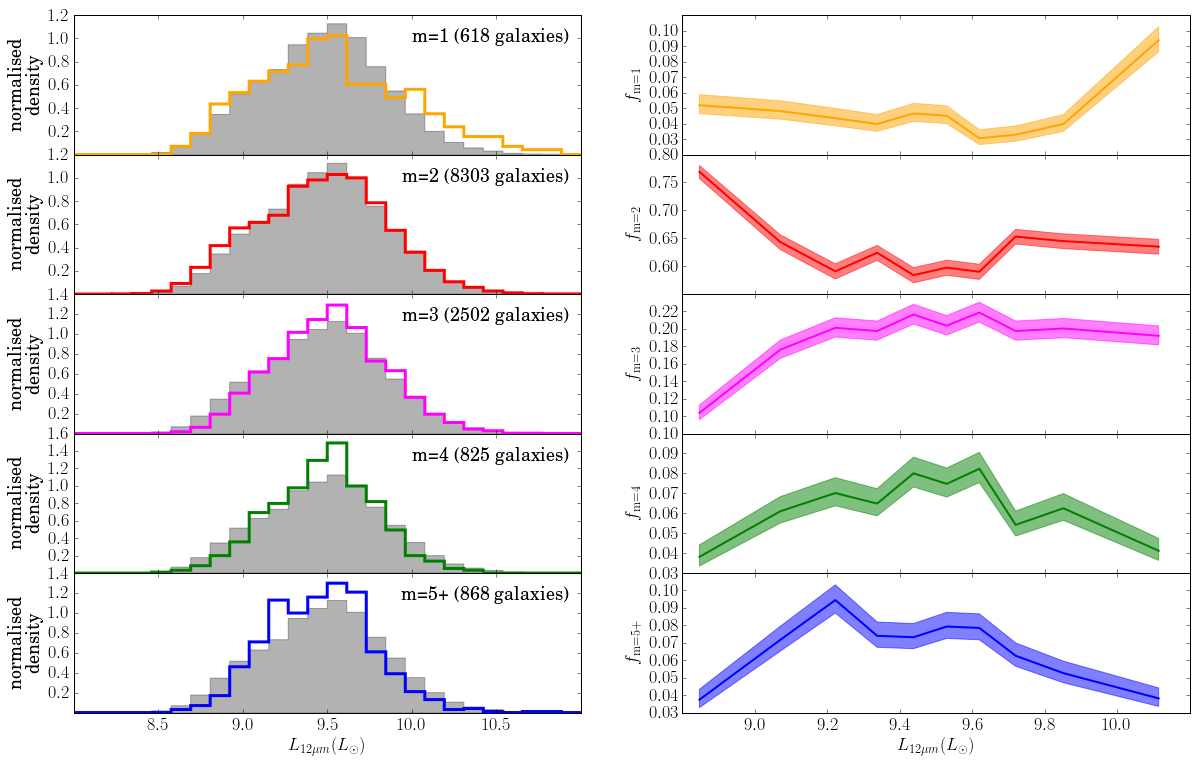

In [20]:
fig,axarr = plt.subplots(5,2,figsize=(20,12.5),sharex=False,sharey=False)
plt.subplots_adjust(hspace=0,wspace=0.2)

column = sw_output_gz[select_spirals][good]['lrest_w3']
arms_good = m_values[select_spirals][good]

axarr1 = axarr[:,0]
axarr2 = axarr[:,1]

for ax in axarr[-1]:
    ax.set_xlabel(r'$L_{12 \mu m} (L_{\odot})$')

histograms(column,arms_good,axarr1,np.linspace(8,11,27),
           reference_column=column)

lines(column,arms_good,axarr2,nbins=10)
axarr = axarr.ravel()

/home/ppxrh/anaconda3/lib/python3.4/site-packages/astropy/table/column.py:206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return self.data.__ne__(other)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


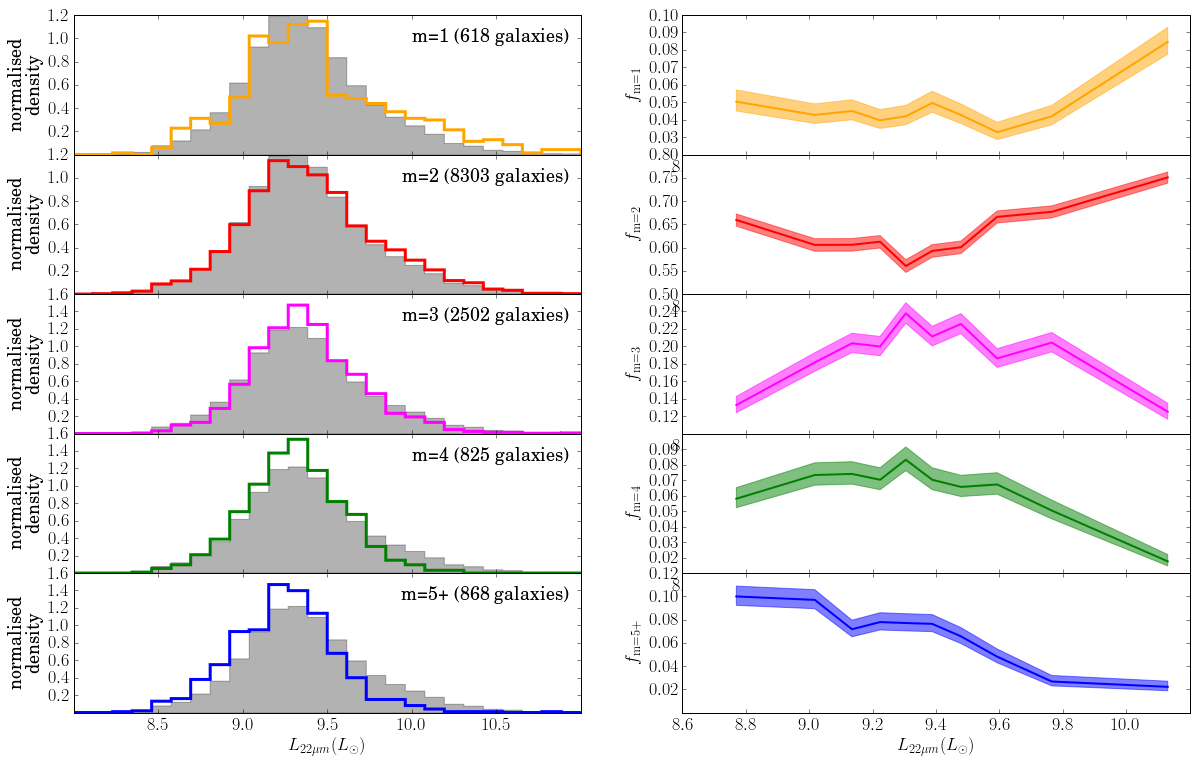

In [21]:
fig,axarr = plt.subplots(5,2,figsize=(20,12.5),sharex=False,sharey=False)
plt.subplots_adjust(hspace=0,wspace=0.2)

column = sw_output_gz[select_spirals][good]['lrest_w4']
arms_good = m_values[select_spirals][good]

axarr1 = axarr[:,0]
axarr2 = axarr[:,1]

for ax in axarr[-1]:
    ax.set_xlabel(r'$L_{22 \mu m} (L_{\odot})$')

histograms(column,arms_good,axarr1,np.linspace(8,11,27),
           reference_column=column)

lines(column,arms_good,axarr2,nbins=10)
axarr = axarr.ravel()

In [22]:
fluxes = Table.read('../fits/fluxes.fits')

In [23]:
def remove_bad_fluxes(fluxes,bands='UGRIZ',maxerr=0.2,print_values=True):
    
    fracerrs = Table(np.zeros((len(fluxes),len(bands))),names=bands)
    flux_masks = np.zeros((len(fluxes),len(bands)))
    
    for i,b in enumerate(bands):
        flux = fluxes['{}_flux'.format(b)]
        fluxerr = fluxes['{}_fluxerr'.format(b)]
        fracerrs[b] = fluxerr/flux
        flux_masks[:,i] = fluxerr/flux > maxerr
        if print_values:
            print('{} filter: {}/{} with flux error > {}'.format(b,np.sum(flux_masks[:,i]),
                                                                 len(flux_masks[:,i]),maxerr))
            
    full_mask = np.sum(flux_masks,axis=1) == 0
    if print_values:
            print('{}/{} with flux error < {}'.format(np.sum(full_mask),len(full_mask),maxerr))

    return full_mask


def remove_bad_wise_fluxes(fluxes,bands='1234',maxerr=0.2,print_values=True):
    
    fracerrs = Table(np.zeros((len(fluxes),len(bands))),names=bands)
    flux_masks = np.zeros((len(fluxes),len(bands)))
    
    for i,b in enumerate(bands):
        flux = fluxes['flux_w{}'.format(b)]
        fluxerr = fluxes['flux_w{}_e'.format(b)]
        fracerrs[b] = fluxerr/flux
        flux_masks[:,i] = fluxerr/flux > maxerr
        if print_values:
            print('W{} filter: {}/{} with flux error > {}'.format(b,np.sum(flux_masks[:,i]),
                                                                 len(flux_masks[:,i]),maxerr))
            
    full_mask = np.sum(flux_masks,axis=1) == 0
    if print_values:
            print('{}/{} with flux error < {}'.format(np.sum(full_mask),len(full_mask),maxerr))

    return full_mask

In [24]:
select_spirals,m_values = get_spiral_sample(data,questions,in_mass_limit,p_th=None)

14385/228201 selected
m=1: 722/14385 spiral galaxies selected
m=2: 9293/14385 spiral galaxies selected
m=3: 2597/14385 spiral galaxies selected
m=4: 862/14385 spiral galaxies selected
m=5: 911/14385 spiral galaxies selected


/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater
/home/ppxrh/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [25]:
sdss_mask = remove_bad_fluxes(fluxes,maxerr=0.33)
wise_mask = remove_bad_wise_fluxes(sw_input_gz,maxerr=0.33)
flux_mask = ((sdss_mask) & (wise_mask) & (select_spirals))
spirals_,m_values_,sw_output_gz_,fluxes_ = [alpha[flux_mask] for alpha in [data,m_values,sw_output_gz,fluxes]]

U filter: 9116.0/228201 with flux error > 0.33
G filter: 1776.0/228201 with flux error > 0.33
R filter: 1747.0/228201 with flux error > 0.33
I filter: 1502.0/228201 with flux error > 0.33
Z filter: 1011.0/228201 with flux error > 0.33
217589/228201 with flux error < 0.33
W1 filter: 953.0/228201 with flux error > 0.33
W2 filter: 913.0/228201 with flux error > 0.33
W3 filter: 69739.0/228201 with flux error > 0.33
W4 filter: 166617.0/228201 with flux error > 0.33
61455/228201 with flux error < 0.33


In [26]:
def get_mean_fluxes(ugriz,sw_output,m_values):

    columns = [sw_output['lrest_u'],sw_output['lrest_g'],sw_output['lrest_r'],
               sw_output['lrest_i'],sw_output['lrest_z'],sw_output['lrest_w1'],
               sw_output['lrest_w2'],sw_output['lrest_w3'],sw_output['lrest_w4']]
    
    means = np.zeros((5,9))
    errors = np.zeros((5,9))

    for m in range(5):
        m_ok = m_values == m
        for c,column in enumerate(columns):
            means[m,c] = np.mean(column[m_ok])
            errors[m,c] = np.std(column[m_ok])/np.sqrt(len(column[m_ok]))
    
    means = Table(means,names='ugriz1234')
    errors = Table(errors,names='ugriz1234')
    
    return means,errors

In [27]:
flux_means,flux_errors = get_mean_fluxes(spirals_,sw_output_gz_,m_values_)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


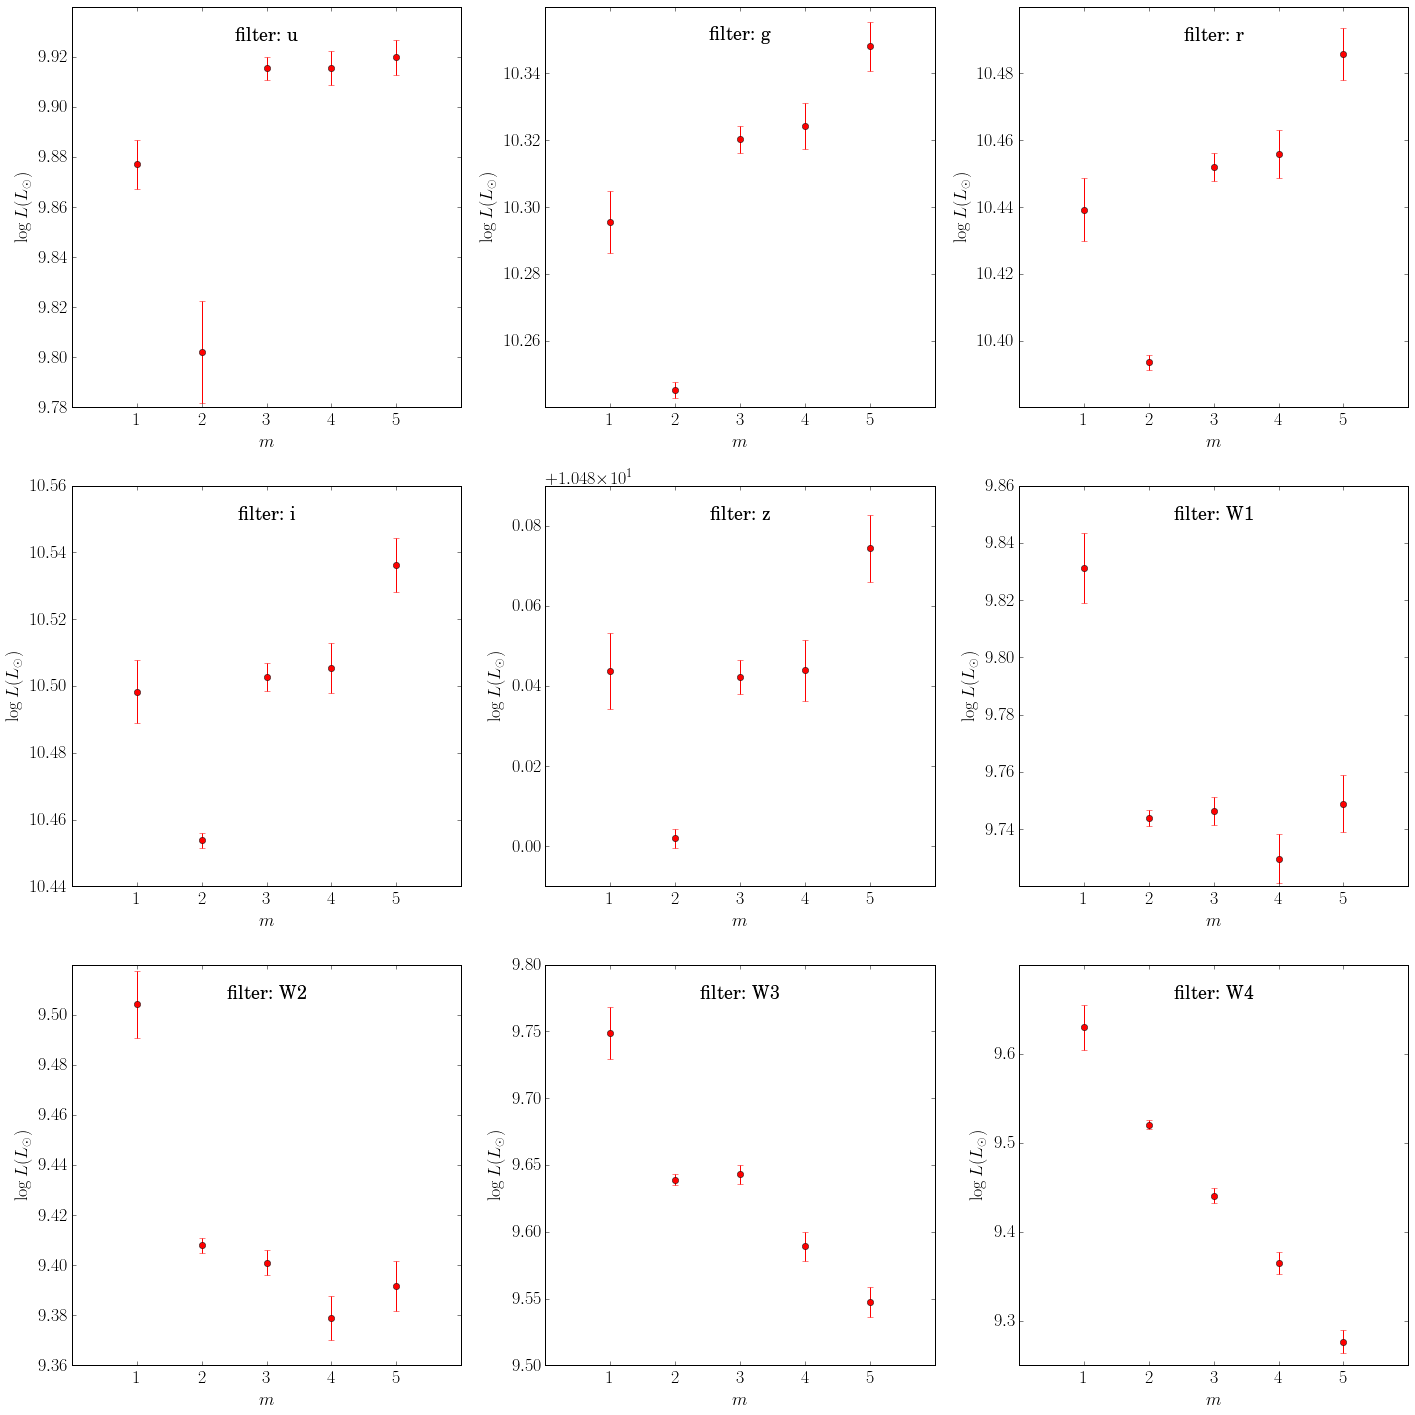

In [28]:
fig,axarr = plt.subplots(3,3,figsize=(20,20))
axarr = axarr.ravel()

labels=['u','g','r','i','z','W1','W2','W3','W4']

for c,colname in enumerate('ugriz1234'):
    
    y = flux_means[colname]
    y_err = flux_errors[colname]
    
    indices = [1,2,3,4,5]
    axarr[c].errorbar(indices,y,yerr=y_err,fmt='ro')
    
    axarr[c].set_xlim([0,6])
    axarr[c].set_xticks(indices)
    axarr[c].text(0.5,0.95,'filter: {}'.format(labels[c]),
                  transform=axarr[c].transAxes,ha='center',va='top')
    
    axarr[c].set_ylabel('$\log{L(L_{\odot})}$')
    axarr[c].set_xlabel('$m$')
    
plt.tight_layout()